- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from scipy import sparse

from core import algorithms, utils
from core.geometry import voronoi_skeleton

Specify case metadata

In [2]:
case = "Liège"

Read road data

In [3]:
roads = utils.read_parquet_roads(case)

Remove duplicated roads

In [4]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Assign COINS-based information to roads

In [5]:
# %%time
roads, coins = algorithms.common.continuity(roads)

Read artifacts

In [6]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [7]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Get nodes from the network.

In [8]:
nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

Link nodes to artifacts

In [9]:
node_idx, artifact_idx = artifacts.sindex.query(
    nodes.buffer(0.1), predicate="intersects"
)
intersects = sparse.coo_array(
    ([True] * len(node_idx), (node_idx, artifact_idx)),
    shape=(len(nodes), len(artifacts)),
    dtype=np.bool_,
)

Compute number of nodes per artifact

In [10]:
artifacts["node_count"] = intersects.sum(axis=0)

Apply additional filters to remove artifacts that are not suitable for simplification. These may be artifacts that:
- are too large in size
- are part of a larger intersection that may need different methods of simplification

In [11]:
area_threshold = 1250  # this is hard to determine but it can be done iteratively using different thresholds
circular_compactness_threshold = 0.15  # same as above

rook = graph.Graph.build_contiguity(artifacts, rook=True)

# keep only those artifacts which occur as isolates, i.e. are not part of a larger intersection
artifacts = artifacts.loc[artifacts.index.intersection(rook.isolates)]

Compute number of stroke groups per artifact.

In [12]:
def _get_stroke_info(artifacts, roads):
    strokes = []
    c_ = []
    e_ = []
    s_ = []
    for geom in artifacts.geometry:
        singles = 0
        ends = 0
        edges = roads.iloc[roads.sindex.query(geom, predicate="covers")]
        if (  # roundabout special case
            edges.coins_group.nunique() == 1
            and edges.shape[0] == edges.coins_count.iloc[0]
        ):
            singles = 1
            mains = 0
        else:
            all_ends = edges[edges.coins_end]
            mains = edges[
                ~edges.coins_group.isin(all_ends.coins_group)
            ].coins_group.nunique()

            visited = []
            for coins_count, group in zip(
                all_ends.coins_count, all_ends.coins_group, strict=True
            ):
                if (group not in visited) and (
                    coins_count == (edges.coins_group == group).sum()
                ):
                    singles += 1
                    visited.append(group)
                elif group not in visited:
                    ends += 1
                    # do not add to visited as they may be disjoint within the artifact
        strokes.append(edges.coins_group.nunique())
        c_.append(mains)
        e_.append(ends)
        s_.append(singles)
    return strokes, c_, e_, s_


strokes, c_, e_, s_ = _get_stroke_info(artifacts, roads)
artifacts["stroke_count"] = strokes
artifacts["C"] = c_
artifacts["E"] = e_
artifacts["S"] = s_

Filer artifacts caused by non-planar intersections.

In [13]:
artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
a_idx, r_idx = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
artifacts.iloc[np.unique(a_idx), -1] = True

Count intersititial nodes (primes).

In [14]:
artifacts["interstitial_nodes"] = artifacts.node_count - artifacts[["C", "E", "S"]].sum(
    axis=1
)

Define the type label.

In [15]:
ces_type = []
for x in artifacts[["node_count", "C", "E", "S"]].itertuples():
    ces_type.append(f"{x.node_count}{'C' * x.C}{'E' * x.E}{'S' * x.S}")
artifacts["ces_type"] = ces_type

Count the frequency of types.

In [16]:
(artifacts.ces_type.value_counts() / len(artifacts) * 100).round(1)

ces_type
3CES     19.3
2CS      16.5
1E       13.1
1S        5.0
3CEE      3.8
         ... 
5EEE      0.1
4CCEE     0.1
7S        0.1
4ES       0.1
8CS       0.1
Name: count, Length: 63, dtype: float64

Filter one type.

In [17]:
artifacts[artifacts.ces_type == "3CC"]

,geometry,face_artifact_index,id,node_count,stroke_count,C,E,S,non_planar,interstitial_nodes,ces_type
1737,"POLYGON ((681763.761 5606905.298, 681764.734 5...",2.843663,1737,3,2,2,0,0,False,1,3CC


Explore typology.

In [18]:
# m = roads.explore(
#     "coins_len",
#     k=20,
#     scheme="quantiles",
#     tiles="cartodb positron",
#     prefer_canvas=True,
#     name="Roads",
#     highlight_kwds={"color": "red"},
#     style_kwds=dict(weight=5),
#     max_zoom=52,
#     opacity=0.5,
# )
# artifacts[artifacts.ces_type == "3CC"].explore(m=m, name="Artifacts", color="red")
# nodes.explore(m=m, name="Nodes", color="blue", marker_size=250)
# folium.LayerControl().add_to(m)
# plugins.MousePosition().add_to(m)

# m

TODO - 3CC plananrity checks

Define placeholders for generic functions fixing the issues.

In [19]:
def n1_g1_identical(edges, *, to_drop):
    """If there is only 1 continuity group {C, E, S} and only 1 node

    - drop the edge

    TODO: Maybe generate dead-end to centroid; check elongation and conditionally apply
    dead end solution (possibly hausdorff point approximation by cutting linestring in
    2; convex hull thingy)

    Parameters
    ----------
    edges : GeoDataFrame
        geometries forming the artifact
    to_drop : list
        list collecting geometries to be dropped
    """
    to_drop.append(edges.index[0])


def nx_gx_identical(edges, *, geom, to_drop, to_add, nodes):
    """If there are  1+ identical continuity groups, and more than 1 node (n>=2)

    - drop all of them and link the entry points to the centroid

    TODO: ensure all is within the artifact; proportionally to area and perimeter create
    some elongation rule and skeletonize (when there are 2 or 3 nodes we can always do
    it)

    Parameters
    ----------
    edges : GeoDataFrame
        geometries forming the artifact
    geom : shapely.Polygon
        polygonal representation of the artifact
    to_drop : list
        list collecting geometries to be dropped
    to_add : list
        list collecting geometries to be added
    nodes : GeoSeries
        nodes forming the artifact
    """
    centroid = geom.centroid
    relevant_nodes = nodes.iloc[nodes.sindex.query(geom, predicate="intersects")]

    to_drop.extend(edges.index.to_list())
    to_add.extend(shapely.shortest_line(relevant_nodes, centroid).to_list())


def nx_gx(edges, *, artifact, to_drop, to_add, split_points, nodes, distance=2):
    """
    Drop all but highest hierarchy. If there are unconnected nodes after drop, connect
    to nearest remaining edge or nearest intersection if there are more remaining edges.
    If there three or more of the highest hierarchy, use roundabout solution.

    If, after dropping, we end up with more than one connected components based on
    remaining edges, create a connection either as a shortest line between the two or
    using skeleton if that is not inside or there are 3 or more components.

    Connection point should ideally be an existing nearest node with degree 4 or above.
    """

    # filter ends
    all_ends = edges[edges.coins_end]

    # determine if we have C present or not. Based on that, ensure that we correctly pick-up
    # the highest hierarchy and drop all lower
    if artifact.C > 0:
        # define mask for E and S strokes
        es_mask = edges.coins_group.isin(all_ends.coins_group)
        # filter Cs
        highest_hierarchy = edges[~es_mask]
    else:
        singles = set()
        visited = []
        for coins_count, group in zip(
            all_ends.coins_count, all_ends.coins_group, strict=True
        ):
            if (group not in visited) and (
                coins_count == (edges.coins_group == group).sum()
            ):
                singles.add(group)
                visited.append(group)
        # filter ends
        all_ends = edges[edges.coins_group.isin(singles)]
        # define mask for E and S strokes
        es_mask = edges.coins_group.isin(all_ends.coins_group)
        # filter Cs
        highest_hierarchy = edges[~es_mask]

    # get nodes forming the artifact
    relevant_nodes = nodes.iloc[
        nodes.sindex.query(artifact.geometry, predicate="dwithin", distance=1e-6)
    ]
    # filter nodes that lie on Cs (possibly primes)
    nodes_on_cont = relevant_nodes.index[
        relevant_nodes.sindex.query(
            highest_hierarchy.geometry.union_all(), predicate="dwithin", distance=1e-6
        )
    ]
    # get nodes that are not on Cs
    remaining_nodes = relevant_nodes.drop(nodes_on_cont)

    # get all remaining geometries and determine if they are all connected or new
    # connections need to happen
    remaining_geoms = pd.concat([remaining_nodes.geometry, highest_hierarchy.geometry])
    heads_ix, tails_ix = remaining_geoms.sindex.query(
        remaining_geoms, predicate="intersects"
    )
    n_comps = graph.Graph.from_arrays(heads_ix, tails_ix, 1).n_components

    # add list of existing edges to be removed from the network
    to_drop.extend(edges[es_mask].index.tolist())

    # more than one component in the remaining geometries
    # (either highest_hierarchy or remaining nodes)
    if n_comps > 1:
        print("CONDITION n_comps > 1 True")

        # get nodes that are relevant snapping targets (degree 4+)
        relevant_targets = relevant_nodes.loc[nodes_on_cont].query("degree > 3")

        cont_comp_labels = graph.Graph.build_contiguity(
            highest_hierarchy, rook=False
        ).component_labels
        conts_groups = highest_hierarchy.dissolve(cont_comp_labels)

        # BRANCH 1 - multiple Cs
        if len(highest_hierarchy) > 1:
            print("CONDITION len(highest_hierarchy) > 1 True")

            # Get nodes on Cs
            bd_points = highest_hierarchy.boundary.explode()
            # Identify nodes on primes
            primes = bd_points[bd_points.duplicated()]

            # For CCSS we need a special case solution if the lenght of S is significantly
            # shorter than the lenght of C. In that case, Voronoi does not create shortest
            # connections but a line that is parallel to Cs.
            if (
                highest_hierarchy.coins_group.nunique() == 2
                and artifact.S == 2
                and (highest_hierarchy.length.sum() > all_ends.length.sum())
            ):
                print("CONDITION for CCSS special case True")

                # this also appends to split_points
                new_connections = algorithms.simplify.ccss_special_case(
                    primes,
                    conts_groups,
                    highest_hierarchy,
                    relevant_nodes,
                    split_points,
                )

            else:
                print("CONDITION for CCSS special case False")

                # Get new connections via skeleton
                new_connections, splitters = voronoi_skeleton(
                    edges.geometry,  # use all edges as an input
                    poly=artifact.geometry,
                    snap_to=relevant_targets.geometry,  # snap to nodes
                    distance=distance,
                    # buffer = highest_hierarchy.length.sum() * 1.2
                )
                split_points.extend(splitters)

                # The skeleton returns connections to all the nodes. We need to keep only
                # some, if there are multiple connections to a single C. We don't touch
                # the other.

                (
                    new_connections,
                    connections_intersecting_c,
                    connections_intersecting_primes,
                ) = algorithms.simplify.filter_connections(
                    primes, conts_groups, new_connections
                )

                # mutliple Cs that are not intersecting. Avoid forks on the ends of Voronoi. If
                # one goes to relevant node, keep it. If not, remove both and replace with
                # a new shortest connection
                if (
                    len(connections_intersecting_c) > 1
                    and len(connections_intersecting_primes) == 0
                ):
                    # this also appends to split_points
                    new_connections = algorithms.simplify.avoid_forks(
                        highest_hierarchy,
                        new_connections,
                        relevant_targets,
                        artifact,
                        split_points,
                    )

                # check for disconnected Cs and reconnect
                new_connections = algorithms.simplify.reconnect(
                    conts_groups, new_connections, artifact, split_points
                )

                # the drop above could've introduced a dangling edges. Remove those.
                new_connections = algorithms.simplify.remove_dangles(
                    new_connections, artifact
                )

        # BRANCH 2 - relevant node targets exist
        elif relevant_targets.shape[0] > 0:
            print("CONDITION relevant_targets.shape[0] > 0 True")

            # SUB BRANCH - only one remaining node
            if remaining_nodes.shape[0] < 2:
                print("CONDITION remaining_nodes.shape[0] < 2 True")

                # this also appends to split_points
                new_connections = algorithms.simplify.one_remaining(
                    relevant_targets,
                    remaining_nodes,
                    artifact,
                    edges,
                    es_mask,
                    distance,
                    split_points,
                )

            # SUB BRANCH - more than one remaining node
            else:
                print("CONDITION remaining_nodes.shape[0] < 2 False")

                # this also appends to split_points
                new_connections = algorithms.simplify.multiple_remaining(
                    edges,
                    es_mask,
                    artifact,
                    distance,
                    highest_hierarchy,
                    split_points,
                    relevant_targets.geometry,
                )

        # BRANCH 3 - no target nodes - snapping to C
        else:
            print("CONDITION relevant_targets.shape[0] > 0 False, snapping to C")

            # SUB BRANCH - only one remaining node
            if remaining_nodes.shape[0] < 2:
                print("CONDITION remaining_nodes.shape[0] < 2 True")

                # this also appends to split_points
                new_connections = algorithms.simplify.one_remaining_c(
                    remaining_nodes,
                    highest_hierarchy,
                    artifact,
                    edges,
                    es_mask,
                    distance,
                    split_points,
                )

            # SUB BRANCH - more than one remaining node
            else:
                print("CONDITION remaining_nodes.shape[0] < 2 False")

                # this also appends to split_points
                new_connections = algorithms.simplify.multiple_remaining(
                    edges,
                    es_mask,
                    artifact,
                    distance,
                    highest_hierarchy,
                    split_points,
                    highest_hierarchy.dissolve("coins_group").geometry,
                )

            new_connections = algorithms.simplify.reconnect(
                conts_groups, new_connections, artifact, split_points
            )

        # add new connections to a list of features to be added to the network
        to_add.extend(list(new_connections))

    # there may be loops or half-loops we are dropping. If they are protruding enough
    # we want to replace them by a deadend representing their space
    elif artifact.C == 1 and (artifact.E + artifact.S) == 1:
        print("CONDITION is_loop True")

        dangles = algorithms.simplify.loop(
            edges, es_mask, highest_hierarchy, artifact, distance, split_points
        )
        if len(dangles) > 0:
            to_add.extend(dangles)

## To-do:

- Post-processing step snapping nearby nodes together. In case of clusters, do that iteratively.


## WIP

Section below is dev code which will likely significantly change.

`highest_hierarchy == "C"`

In [20]:
data_sample = artifacts[(artifacts.C > 0) & ((artifacts.E + artifacts.S) > 0)].sample(
    50
)
data_sample = artifacts.loc[[2818]]

Below is a draft of the `nx_gx` function.

In [21]:
distance = 2
# collect changes
to_drop = []
to_add = []
split_points = []

for artifact in data_sample.itertuples():
    print(artifact.Index)

    # get edges relevant for an artifact
    edges = roads.iloc[roads.sindex.query(artifact.geometry, predicate="covers")]

    nx_gx(
        edges,
        artifact=artifact,
        to_drop=to_drop,
        to_add=to_add,
        split_points=split_points,
        nodes=nodes,
        distance=distance,
    )


cleaned_roads = roads.geometry.drop(to_drop)
# split lines on new nodes
cleaned_roads = algorithms.simplify.split(split_points, cleaned_roads, roads)

# create new roads with fixed geometry. Note that to_add and to_drop lists shall be
# global and this step should happen only once, not for every artifact
new_roads = pd.concat(
    [
        cleaned_roads,
        gpd.GeoSeries(to_add, crs=roads.crs).line_merge().simplify(distance),
    ],
    ignore_index=True,
)
new_roads = momepy.remove_false_nodes(new_roads[~new_roads.is_empty])

2818
CONDITION n_comps > 1 True
CONDITION len(highest_hierarchy) > 1 True
CONDITION for CCSS special case True


In [22]:
artifact = artifacts.loc[2818]

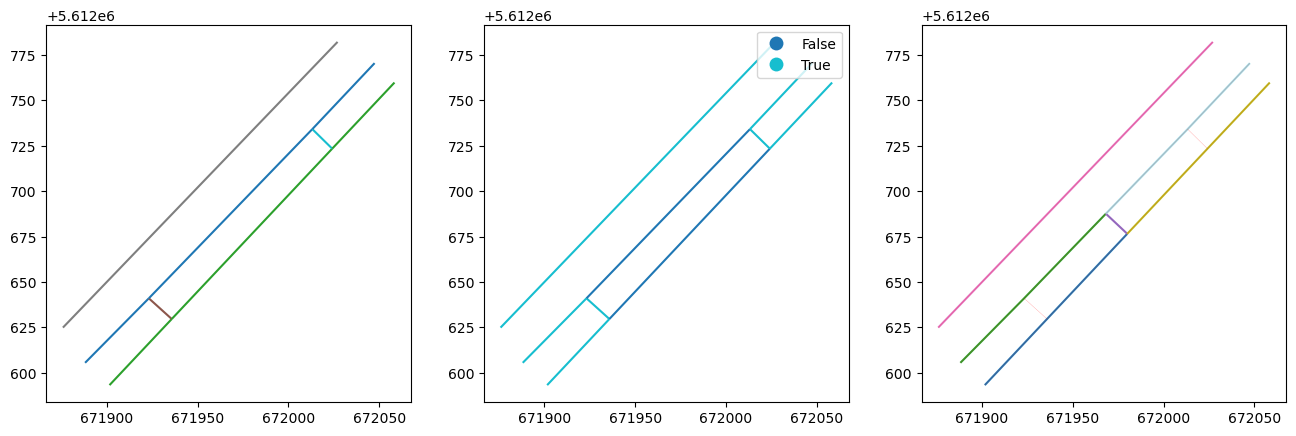

In [23]:
# for artifact in data_sample.itertuples():
#     print(artifact.Index)
# plot the results for visual verification
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
geom = artifact.geometry
# geom.plot(hatch="//", ax=axs[0], color="none")
roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
# geom.plot(hatch="//", ax=axs[1], color="none")
roads.clip(geom.buffer(50)).plot("coins_end", ax=axs[1], categorical=True, legend=True)
new_roads.clip(geom.buffer(50)).plot(ax=axs[2], zorder=2, cmap="tab20")
roads.clip(geom.buffer(50)).plot(
    color="red",
    ax=axs[2],
    # categorical=True,
    # legend=True,
    linewidth=0.1,
)
plt.show()